# Imports and File Locations

In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [2]:
ext_data = '../data/external/'
raw_data = '../data/raw/'
interim_data = '../data/interim/'

# Read Parcel file into dataframe

In [3]:
parcel_df = pd.read_pickle(raw_data + 'parcel_df.pkl')

In [4]:
print(parcel_df.shape)
print(parcel_df.info())

(512207, 47)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512207 entries, 0 to 512206
Data columns (total 47 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   FOLIO      512207 non-null  object 
 1   TYPE       512207 non-null  object 
 2   Edit_dt    512207 non-null  object 
 3   PIN        512207 non-null  object 
 4   DOR_C      512207 non-null  object 
 5   OWNER      512207 non-null  object 
 6   ADDR_1     512207 non-null  object 
 7   ADDR_2     512207 non-null  object 
 8   CITY       512207 non-null  object 
 9   STATE      512207 non-null  object 
 10  ZIP        512207 non-null  object 
 11  COUNTRY    512207 non-null  object 
 12  SUB        512207 non-null  object 
 13  SITE_ADDR  512207 non-null  object 
 14  SITE_CITY  512207 non-null  object 
 15  SITE_ZIP   512207 non-null  object 
 16  LEGAL1     512207 non-null  object 
 17  LEGAL2     512207 non-null  object 
 18  LEGAL3     512207 non-null  object 
 19  LEGAL4    

In [5]:
parcel_df.head().T

,0,1,2,3,4
FOLIO,0000010000,0000050000,0000080000,0000080100,0000090000
TYPE,,,,,
Edit_dt,2019-04-08,2019-04-08,2019-04-09,2019-04-09,2019-04-09
PIN,A-23-33-15-ZZZ-000000-00020.0,A-23-33-15-ZZZ-000000-00040.0,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.1,U-01-27-17-001-000000-00002.0
DOR_C,8800,8600,0000,0100,0100
OWNER,UNITED STATES,HILLSBOROUGH COUNTY,PAULINE L SEVIGNY/ LIFE ESTATE,JEFFERY AND PATRICIA SEVIGNY,MARIETTA SHIVER LIFE ESTATE
ADDR_1,EGMONT KEY STATE PARK,REAL ESTATE DEPT,19931 ANGEL LN,19859 ANGEL LN,19901 ANGEL LN
ADDR_2,4905 34TH ST S PMB 5000,PO BOX 1110,,,
CITY,SAINT PETERSBURG,TAMPA,ODESSA,ODESSA,ODESSA
STATE,FL,FL,FL,FL,FL


In [6]:
# Replace blank strings with NaN
parcel_df = parcel_df.replace(r'^\s*$', np.NaN, regex=True)

In [7]:
print(parcel_df.isna().sum())

FOLIO             1
TYPE         512206
Edit_dt           0
PIN              28
DOR_C            28
OWNER            80
ADDR_1          815
ADDR_2       492466
CITY           1121
STATE          3104
ZIP            3087
COUNTRY      510202
SUB              28
SITE_ADDR        28
SITE_CITY       580
SITE_ZIP        481
LEGAL1           32
LEGAL2         4362
LEGAL3       409558
LEGAL4       460920
DBA          476677
STRAP            28
tBEDS             0
tBATHS            0
tSTORIES          0
tUNITS            0
tBLDGS            0
TAXDIST          28
JUST              0
LAND              0
BLDG              0
EXF               0
ACT               0
EFF               0
HEAT_AR           0
ASD_VAL           0
TAX_VAL           0
MUNI             28
SD1          391945
SD2          509168
TIF          466465
BASE              0
S_DATE        87780
VI           102700
S_AMT             0
ACREAGE           0
NBHC              0
dtype: int64


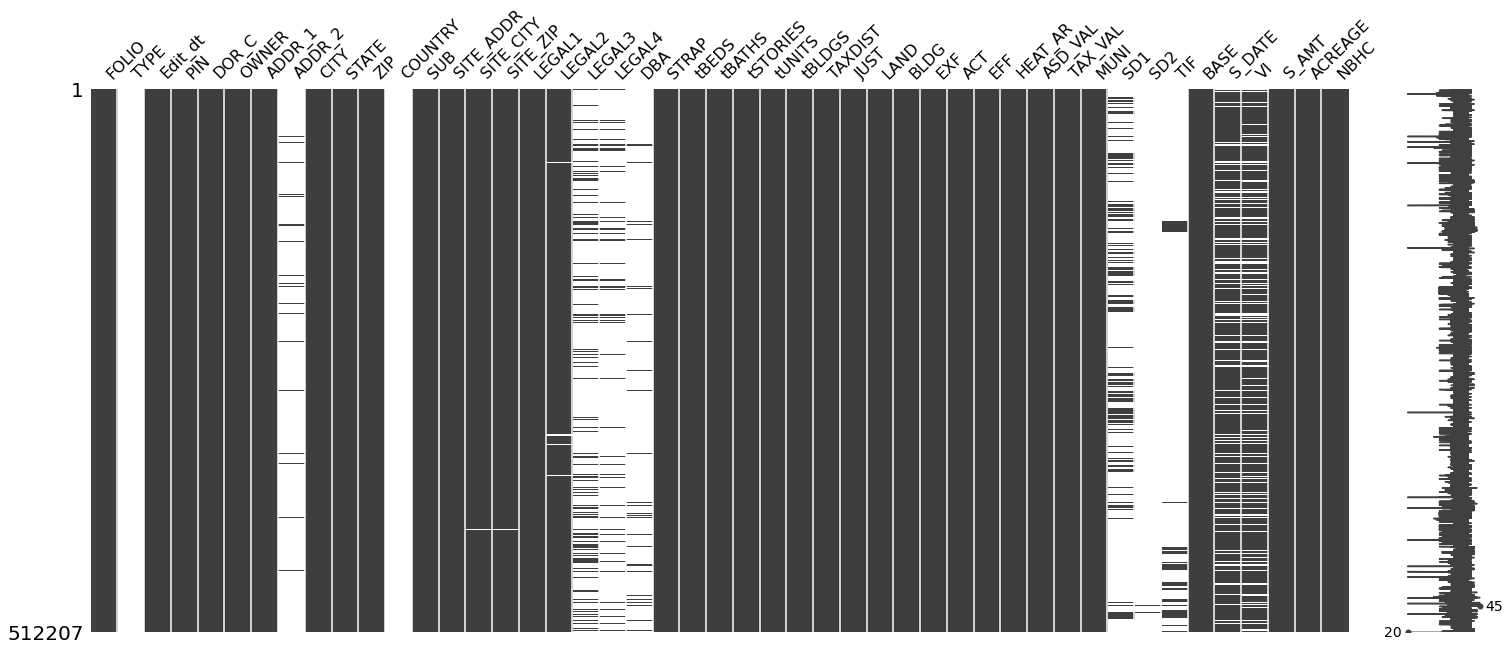

In [8]:
# Visualize missingness matrix
msno.matrix(parcel_df)
plt.show()

### Drop columns where data is missing or not valuable
- TYPE: empty
- Edit_dt: date mapping polygon was last updated
- COUNTRY: empty
- LEGAL1: legal description line 1 (text description; legal codes found in other columns)
- LEGAL2: legal description line 2 (text description; legal codes found in other columns)
- LEGAL3: legal description line 3 (text description; legal codes found in other columns)
- LEGAL4: legal description line 4 (text description; legal codes found in other columns)
- DBA: Doing Business As; business name
- STRAP: unformatted PIN number (duplicate data)
- S_DATE: last sale date of qualified [free market] sales only since 1906 (sale dates will be obtained from sales data)
- S_AMT: last sale amount of qualified sales only (sale amounts will be obtained from sales data)

In [9]:
# Drop columns where data is missing or not valueable
pd_cols = ['TYPE', 'Edit_dt', 'COUNTRY', 'LEGAL1', 'LEGAL2', 'LEGAL3', 'LEGAL4', 'DBA', 'STRAP', 'S_DATE', 'S_AMT']
parcel_df.drop(pd_cols, axis=1, inplace=True)

### Replace Owner Address with owner_occupied category
0. Owner residence out-of-state
1. Owner residence out-of-town
2. Owner primary residence
3. Unknown

In [10]:
def owner_occupied(df):
    """ Return category code based on whether the owner occupies the property
        0. Owner residence out-of-state
        1. Owner residence out-of-town
        2. Owner primary residence
        3. Unknown
    """ 
    owner_zip = str(df['ZIP'])[:5]
    property_zip = str(df['SITE_ZIP'])[:5]
    
    if df['STATE'] != 'FL':
        return 0
    elif owner_zip != property_zip and property_zip != '99999':
        return 1
    elif df['ADDR_1'] == df['SITE_ADDR']:
        return 2
    else:
        return 3
    
parcel_df['OWNER_OCCUPIED'] = parcel_df.apply(owner_occupied, axis=1).astype('category')

In [11]:
pd_cols = ['OWNER', 'ADDR_1', 'ADDR_2', 'CITY', 'STATE', 'ZIP']
parcel_df.drop(pd_cols, axis=1, inplace=True)

In [12]:
print(parcel_df.shape)
print(parcel_df.info())

(512207, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512207 entries, 0 to 512206
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   FOLIO           512206 non-null  object  
 1   PIN             512179 non-null  object  
 2   DOR_C           512179 non-null  object  
 3   SUB             512179 non-null  object  
 4   SITE_ADDR       512179 non-null  object  
 5   SITE_CITY       511627 non-null  object  
 6   SITE_ZIP        511726 non-null  object  
 7   tBEDS           512207 non-null  float64 
 8   tBATHS          512207 non-null  float64 
 9   tSTORIES        512207 non-null  float64 
 10  tUNITS          512207 non-null  float64 
 11  tBLDGS          512207 non-null  float64 
 12  TAXDIST         512179 non-null  object  
 13  JUST            512207 non-null  float64 
 14  LAND            512207 non-null  float64 
 15  BLDG            512207 non-null  float64 
 16  EXF             512207 no

# Read Sales file into dataframe

In [13]:
sales_df = pd.read_pickle(raw_data + 'sales_df.pkl')

In [14]:
print(sales_df.shape)
print(sales_df.info())

(2166282, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166282 entries, 0 to 2166281
Data columns (total 17 columns):
 #   Column    Dtype  
---  ------    -----  
 0   PIN       object 
 1   FOLIO     object 
 2   DOR_CODE  object 
 3   NBHC      float64
 4   S_DATE    object 
 5   VI        object 
 6   QU        object 
 7   REA_CD    object 
 8   S_AMT     float64
 9   SUB       object 
 10  STR       object 
 11  S_TYPE    object 
 12  OR_BK     object 
 13  OR_PG     object 
 14  GRANTOR   object 
 15  GRANTEE   object 
 16  DOC_NUM   object 
dtypes: float64(2), object(15)
memory usage: 281.0+ MB
None


In [15]:
sales_df.head().T

,0,1,2,3,4
PIN,A-23-33-15-ZZZ-000000-00040.0,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.0
FOLIO,0000050000,0000080000,0000080000,0000080000,0000080000
DOR_CODE,8600,0000,0000,0000,0000
NBHC,227002.0,211007.0,211007.0,211007.0,211007.0
S_DATE,1928-03-01,2019-09-16,2014-04-01,2006-12-05,1988-10-01
VI,V,V,V,V,V
QU,U,U,U,U,U
REA_CD,38,11,11,11,38
S_AMT,100.0,100.0,100.0,100.0,28000.0
SUB,ZZZ,001,001,001,001


In [16]:
# Replace blank strings with NaN
sales_df = sales_df.replace(r'^\s*$', np.NaN, regex=True)

In [17]:
print(sales_df.isna().sum())

PIN              0
FOLIO            0
DOR_CODE        18
NBHC             0
S_DATE           0
VI           67887
QU               0
REA_CD       15833
S_AMT            0
SUB              0
STR              0
S_TYPE       79678
OR_BK        14190
OR_PG        14190
GRANTOR     729426
GRANTEE     620707
DOC_NUM     265596
dtype: int64


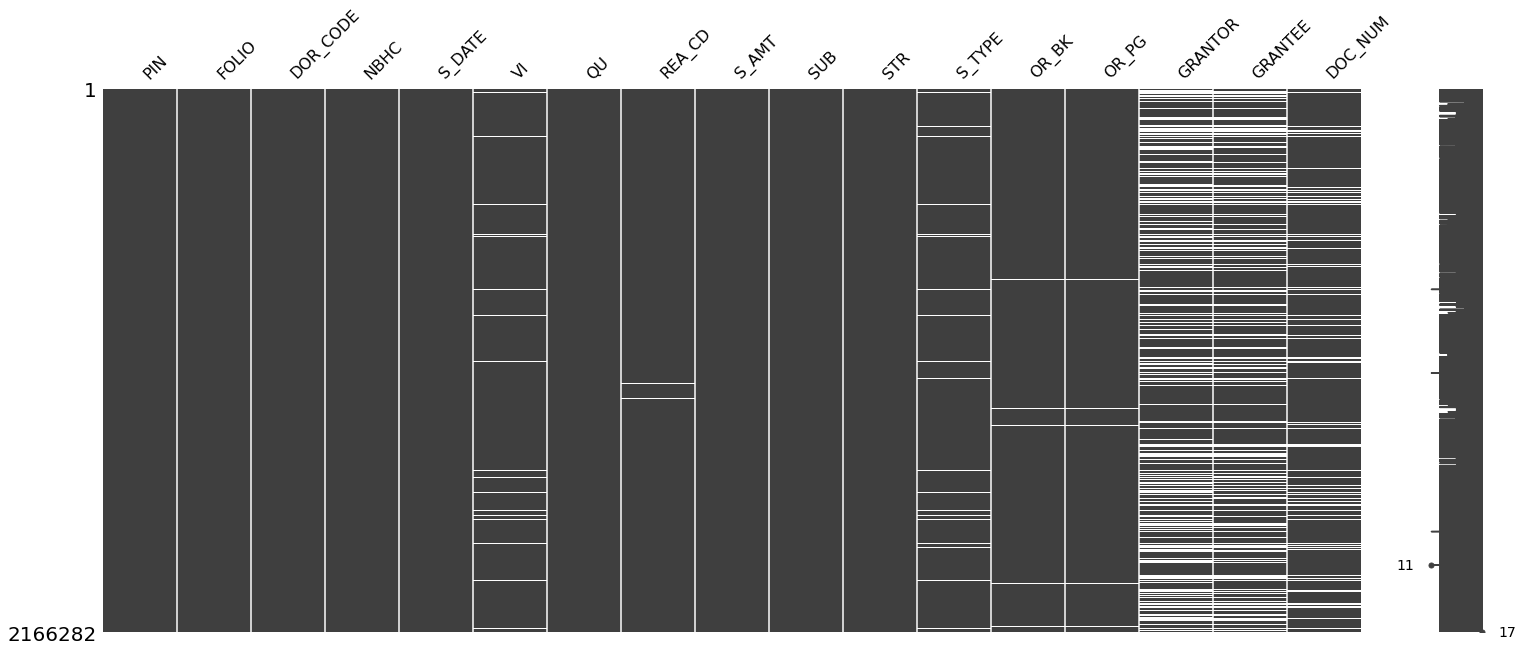

In [18]:
# Visualize missingness matrix
msno.matrix(sales_df)
plt.show()

### Drop columns where data is missing or not valuable
- OR_BK: book number where the deed is recorded
- OR_PG: page number where the deed is recorded
- GRANTOR: seller name
- GRANTEE: buyer name
- DOC_NUM: instrument number from Clerk’s Office

In [19]:
# Drop columns where data is missing or not valueable
sd_cols = ['OR_BK', 'OR_PG', 'GRANTOR', 'GRANTEE', 'DOC_NUM']
sales_df.drop(sd_cols, axis=1, inplace=True)

In [20]:
print(sales_df.shape)
print(sales_df.info())

(2166282, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166282 entries, 0 to 2166281
Data columns (total 12 columns):
 #   Column    Dtype  
---  ------    -----  
 0   PIN       object 
 1   FOLIO     object 
 2   DOR_CODE  object 
 3   NBHC      float64
 4   S_DATE    object 
 5   VI        object 
 6   QU        object 
 7   REA_CD    object 
 8   S_AMT     float64
 9   SUB       object 
 10  STR       object 
 11  S_TYPE    object 
dtypes: float64(2), object(10)
memory usage: 198.3+ MB
None


# Merge Sales and Parcel Data
- Left Merge based on Folio number
- Analyze missing parcel data

In [21]:
sales_df = sales_df.merge(parcel_df, on='FOLIO', how='left', indicator=True, suffixes=('', '_p'))

In [22]:
sales_df.head().T

,0,1,2,3,4
PIN,A-23-33-15-ZZZ-000000-00040.0,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.0
FOLIO,0000050000,0000080000,0000080000,0000080000,0000080000
DOR_CODE,8600,0000,0000,0000,0000
NBHC,227002.0,211007.0,211007.0,211007.0,211007.0
S_DATE,1928-03-01,2019-09-16,2014-04-01,2006-12-05,1988-10-01
VI,V,V,V,V,V
QU,U,U,U,U,U
REA_CD,38,11,11,11,38
S_AMT,100.0,100.0,100.0,100.0,28000.0
SUB,ZZZ,001,001,001,001


In [23]:
parcel_missing = sales_df[sales_df['_merge'] == 'left_only']
parcel_missing.shape

(1404, 43)

In [24]:
# Save sales with missing parcel data to csv
parcel_missing.to_csv(interim_data + 'parcel_missing.csv')

In [25]:
percent_missing = (parcel_missing.shape[0] / sales_df.shape[0]) * 100
print('Percent of sales with missing parcel data: ' + str(round(percent_missing, 3)) + '%')

Percent of sales with missing parcel data: 0.065%


### Drop sales with missing parcel data
- It is unclear as to why 0.065% of the sales data does not have a matching record in the parcel data.
- Further analysis of the missing data would require an investigation into the source systems.
- Decision is to exclude these sales from the analysis.

In [26]:
sales_df = sales_df[sales_df['_merge'] == 'both']
sales_df.drop('_merge', axis=1, inplace=True)
sales_df.shape

(2164878, 42)

In [27]:
sales_df.shape
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2164878 entries, 0 to 2166281
Data columns (total 42 columns):
 #   Column          Dtype   
---  ------          -----   
 0   PIN             object  
 1   FOLIO           object  
 2   DOR_CODE        object  
 3   NBHC            float64 
 4   S_DATE          object  
 5   VI              object  
 6   QU              object  
 7   REA_CD          object  
 8   S_AMT           float64 
 9   SUB             object  
 10  STR             object  
 11  S_TYPE          object  
 12  PIN_p           object  
 13  DOR_C           object  
 14  SUB_p           object  
 15  SITE_ADDR       object  
 16  SITE_CITY       object  
 17  SITE_ZIP        object  
 18  tBEDS           float64 
 19  tBATHS          float64 
 20  tSTORIES        float64 
 21  tUNITS          float64 
 22  tBLDGS          float64 
 23  TAXDIST         object  
 24  JUST            float64 
 25  LAND            float64 
 26  BLDG            float64 
 27  EXF         

# PIN
- Validate format
- Unpack data elements into new columns
- Drop original column

The PIN number is the parcel identifier and is formatted as follows.

Example PIN: A-16-28-19-3A3-000034-00004.0

A 16 28 19 3A3 000034 00004.0 (Municipality) (Section) (Township) (Range) (Land Type-ID) (Block# ) (Lot#)

The MUNICIPALITY CODE indicates whether the property is located in a city or unincorporated county. The code for the City of Tampa is "A", for the City of Temple Terrace "T" and for the City of Plant City "P". All unincorporated county is coded with "U".

The SECTION-TOWNSHIP-RANGE

The Land Type-ID is to further identify the type of land. All platted Subdivisions and Condominiums have been assigned an ID number. This number may be a combination of numbers and letters, such as "3A3". Not all property in the county is platted. For all unplatted, metes and bounds described lands a Land Type-ID of "ZZZ" has been assigned. This way, one look at the PIN number can tell you whether it is platted or unplatted land.

The BLOCK# is 6 digits and will hold the Block Number in platted Subdivisions or Building Number in a Condominium. For unplatted land having a Land Type-ID of "ZZZ" the BLOCK# will carry a uniquely assigned number.

The LOT# is 6 digits and will hold the Lot Numbers in Platted Subdivisions or Unit Numbers in a Condominium. For all unplatted land having a Land Type-ID of "ZZZ" the LOT# will carry a uniquely assigned number.

In [28]:
print(sales_df['PIN'].describe())

count                           2164878
unique                           503099
top       U-36-27-18-ZZZ-000000-75670.1
freq                                 91
Name: PIN, dtype: object


In [29]:
# Validate all PIN's match format (i.e. 'A-16-28-19-3A3-000034-00004.0')
pin = sales_df['PIN'].str.match("^[A-Z]-\d{2}-\d{2}-\d{2}-[A-Z0-9]{3}-[A-Z0-9]{6}-[A-Z0-9]{5}\.[A-Z0-9]$")
assert sales_df[~pin].shape[0] == 0

In [30]:
# Split PIN into the seven data elements that are used to create the PIN
pin_fields = ['MUNICIPALITY_CD', 'SECTION_CD', 'TOWNSHIP_CD', 'RANGE_CD', 'LAND_TYPE_ID', 'BLOCK_NUM', 'LOT_NUM']
sales_df[pin_fields] = sales_df['PIN'].str.split('-', expand=True).astype('category')

In [31]:
# FOLIO and PIN (Property Identification Number) are both unique values that describe the properties
# Drop PIN as the values have already been segregated into the 7 data elements that make up the PIN
sales_df.drop(['PIN', 'PIN_p'], axis=1, inplace=True)

# DOR Code
There are almost 300 Department of Revenue (DOR) codes which represent the type of property.  The types of properties include single family homes, condos, malls, night clubs, churches, vacant land, etc. 

In [32]:
# read external list of DOR codes
dor_code_df = pd.read_excel(open(ext_data + '_DOR_CODE_LIST.xlsx','rb'), sheet_name='parcel_dor_names')
dor_code_df.head()

,DORCODE,DORDESCR
0,0000,VACANT RESIDENTIAL
1,0006,VACANT TOWNHOME
2,0008,VACANT MH/CONDO COOP
3,0029,PUBLIC LANDS
4,0040,VACANT CONDO


In [33]:
dor_code_df.describe()

,DORCODE,DORDESCR
count,288,288
unique,288,288
top,0000,VACANT RESIDENTIAL
freq,1,1


In [34]:
print(sales_df['DOR_CODE'].describe())
print('# of missing DOR codes: ' + str(sales_df[sales_df['DOR_CODE'].isna()].shape[0]))

count     2164860
unique        269
top          0100
freq      1498161
Name: DOR_CODE, dtype: object
# of missing DOR codes: 18


In [35]:
# fill missing values of sales DOR_CODE with parcel DOR_C
sales_df['DOR_CODE'].fillna(sales_df['DOR_C'], inplace=True)
assert sales_df[sales_df['DOR_CODE'].isna()].shape[0] == 0

In [36]:
# Query any DOR codes in sales data that do not exist in the DOR code list
sales_dor = sales_df.merge(dor_code_df, left_on='DOR_CODE', right_on='DORCODE', how='left', indicator=True)
dor_list = sales_dor.loc[sales_dor['_merge'] == 'left_only', 'DOR_CODE']
invalid_dor_codes = sales_df[sales_df['DOR_CODE'].isin(dor_list)]

In [37]:
print(invalid_dor_codes.shape)
print(invalid_dor_codes.groupby('DOR_CODE', dropna=False).size())

(4689, 47)
DOR_CODE
1050     203
1421     628
1422     726
1423     255
1750    1425
1751      24
1851      22
1950     668
1951      51
4801      25
4802      56
4803      53
4804      18
7150       4
7301      43
7501     473
7550      11
9929       4
dtype: int64


The other DOR codes that are not in the validation list appear to fall into the following categories:
- 1000 level: Vacant Commercial
- 1400 level: Supermarkets/Convenience Stores
- 1700 level: Office, One-Story
- 1800 level: Office, Multi-Story
- 1900 level: Medical Office
- 4800 level: Warehouse/Distribution Terminals
- 7100 level: Churches
- 7300 level: Hospitals
- 7500 level: Non-Profit Services
- 9900 level: Vacant Acreage

For this analysis, the following residential property types will be used:
- 0100: Single Family Residential
- 0102: Single family home built around a mobile home
- 0106: Townhouse/Villa
- 0200: Mobile Home
- 0400: Condominium
- 0408: Mobile Home Condominium
- 0800: Multi-Family Residential (Duplex, Triplex, Quadplex, etc.) < 10 units
- 0801: Multi-Family Residential (units individually owned)
- 0802: Multi-Family Residential (units rentals)

In [38]:
dor_residential = ['0100', '0102', '0106', '0200', '0400', '0408', '0800', '0801', '0802']
sales_df = sales_df[sales_df['DOR_CODE'].isin(dor_residential)]

In [39]:
sales_df.shape

(1917468, 47)

In [40]:
sales_df['DOR_CODE'] = sales_df['DOR_CODE'].astype('category')
sales_df.drop('DOR_C', axis=1, inplace=True)

# Sales Date
- Validate no missing values
- Convert to datetime data type
- Evaluate totals
- Drop outlier data

In [41]:
sales_df['S_DATE'].describe()

count        1917468
unique         10928
top       1976-01-01
freq            8486
Name: S_DATE, dtype: object

In [42]:
assert sales_df[sales_df['S_DATE'].isna()].shape[0] == 0

In [43]:
sales_df['S_DATE'] = pd.to_datetime(sales_df['S_DATE'])

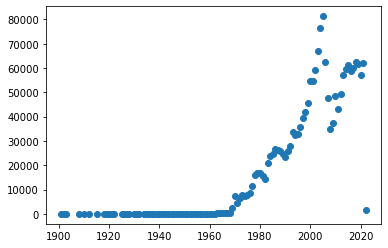

In [44]:
year_totals = pd.DataFrame(sales_df.groupby(sales_df['S_DATE'].dt.year).size())
plt.scatter(year_totals.index, year_totals[0])
plt.show()

In [45]:
# The top date was 1976-01-01 with 8486 sales.
# This appears that some properties may have been initialized with that date.
# Drop data for years prior to 1980
sales_df = sales_df[sales_df['S_DATE'] >= '1980-01-01']
sales_df.shape

(1817623, 46)

# NBHC (Neighborhood Code)
- Validate current values of NBHC_p from Parcel data (Parcel data is current where Sales data could have changed over time)
- Convert NBHC_p to category
- Drop NBHC from Sales data
- Rename NBHC_p to NBHC

In [99]:
print(sales_df['NBHC_p'].astype('category').describe())
print(sales_df.groupby('NBHC_p', dropna=False).size())

count     847102.0
unique       313.0
top       228003.0
freq       20376.0
Name: NBHC_p, dtype: float64
NBHC_p
201001.0    3611
201002.0    5300
201003.0    4175
201004.0    2723
201005.0    2853
            ... 
229003.0    1248
229004.0      58
229006.0    2575
229007.0     108
229008.0    2131
Length: 313, dtype: int64


In [103]:
sales_df['NBHC_p'] = sales_df['NBHC_p'].astype('category')
sales_df.drop('NBHC', axis=1, inplace=True)
sales_df.rename(columns = {'NBHC_p': 'NBHC'}, inplace=True)

# VI (Vacant or Improved at time of sale)
- Validate current values of 'V', 'I', NaN
- Impute missing values
- Convert to category
- Drop VI_p parcel column

In [46]:
print(sales_df['VI'].describe())
print(sales_df.groupby('VI', dropna=False).size())

count     1816646
unique          2
top             I
freq      1482652
Name: VI, dtype: object
VI
I      1482652
V       333994
NaN        977
dtype: int64


In [47]:
# fill missing values of sales VI with parcel VI_p
sales_df['VI'].fillna(sales_df['VI_p'], inplace=True)
print(sales_df.groupby('VI', dropna=False).size())

VI
I      1483289
V       334037
NaN        297
dtype: int64


In [48]:
# Analyze missing VI codes
missing_vi = sales_df[sales_df['VI'].isna()]
print(missing_vi.groupby(missing_vi['S_DATE'].dt.year).size())

S_DATE
1980    19
1981    26
1982    28
1983    21
1984    17
1985    16
1986    36
1987    45
1988    56
1989    22
1990     9
1992     1
1998     1
dtype: int64


In [49]:
# remaining missing values of sales VI appear to be older sales records...assume Improved
sales_df['VI'].fillna('I', inplace=True)
assert sales_df[sales_df['VI'].isna()].shape[0] == 0

In [50]:
sales_df['VI'] = sales_df['VI'].astype('category')
sales_df.drop('VI_p', axis=1, inplace=True)

# QU (Qualified or Unqualified)
Qualified sales are free market sales and are used by the Property Appraiser to determine property values.
Unqualified sales are multi-parcel sales, deed transfers, or sales with other considerations than money.
For this analysis, Unqualified sales should be excluded.
- Validate only Q and U exist
- Remove Unqualified sales
- Convert column to category

In [51]:
print(sales_df['QU'].describe())
print(sales_df.groupby('QU', dropna=False).size())

count     1817623
unique          2
top             U
freq       970430
Name: QU, dtype: object
QU
Q    847193
U    970430
dtype: int64


In [52]:
sales_df = sales_df[sales_df['QU'] == 'Q']

In [53]:
sales_df.shape

(847193, 45)

In [54]:
sales_df['QU'] = sales_df['QU'].astype('category')

# REA Code (Reason Code for Qualified or Unqualified)
- Validate current values 
- Impute missing values
- Convert to category

In [55]:
print(sales_df['REA_CD'].describe())
print(sales_df.groupby('REA_CD', dropna=False).size())

count     832669
unique        25
top           01
freq      543708
Name: REA_CD, dtype: object
REA_CD
01     543708
02     255255
05        215
11         17
12         19
13          1
14          2
18         21
19          3
20          6
21          1
2A      15502
2B      15440
30         16
32         97
34          2
35          2
37         33
38        238
3A         59
3B        243
3C       1729
3D         57
40          1
98          2
NaN     14524
dtype: int64


In [56]:
# set missing reason codes to '00' since there is no way to determine the correct reason code without in depth research into source systems
sales_df['REA_CD'].fillna('00', inplace=True)
assert sales_df[sales_df['REA_CD'].isna()].shape[0] == 0

In [57]:
sales_df['REA_CD'] = sales_df['REA_CD'].astype('category')

# Sale Amount
- Validate current values

In [58]:
print(sales_df['S_AMT'].describe().apply(lambda x: format(x, 'f')))

count      847193.000000
mean       199161.203110
std        422183.918268
min            47.000000
25%         76600.000000
50%        142000.000000
75%        235000.000000
max      41200000.000000
Name: S_AMT, dtype: object


The Sales Amounts are skewed by low values that appear to be invalid.
- The minimum amount is \$47
- Create bins to remove outliers

In [59]:
amt_bins = [0, 1000, 10000, 50000, 100000, 500000, 1000000, 10000000, 30000000, 50000000]
amt_bins.append(float('inf'))
sales_df['S_AMT_BIN'] = pd.cut(sales_df['S_AMT'], bins=amt_bins)

In [60]:
sales_df.groupby('S_AMT_BIN').size()

S_AMT_BIN
(0.0, 1000.0]                   72
(1000.0, 10000.0]             4326
(10000.0, 50000.0]          101369
(50000.0, 100000.0]         194039
(100000.0, 500000.0]        512358
(500000.0, 1000000.0]        27375
(1000000.0, 10000000.0]       7185
(10000000.0, 30000000.0]       450
(30000000.0, 50000000.0]        19
(50000000.0, inf]                0
dtype: int64

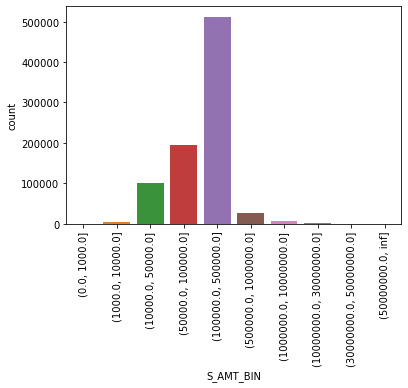

In [61]:
ax = sns.countplot(data=sales_df, x='S_AMT_BIN')
ax.tick_params(axis='x', labelrotation=90)

In [62]:
sales_df[sales_df['S_AMT'] >= 30000000].T

,1137409,2067134,2086229,2086250,2086287,2086293,2086299,2086303,2086322,2086337,2094637,2094646,2094647,2094649,2094651,2094653,2094655,2094658,2094663
FOLIO,0747436720,1946585258,1988400516,1988400522,1988400540,1988400544,1988400546,1988400548,1988400554,1988400558,1995130702,1995130708,1995130708,1995130710,1995130712,1995130714,1995130716,1995130718,1995130720
DOR_CODE,0100,0400,0100,0100,0100,0100,0100,0100,0100,0100,0100,0100,0100,0100,0100,0100,0100,0100,0100
NBHC,224005.0,803088.0,203013.0,203013.0,203013.0,203013.0,203013.0,203013.0,203013.0,203013.0,203013.0,203013.0,203013.0,203013.0,203013.0,203013.0,203013.0,203013.0,203013.0
S_DATE,1982-03-01 00:00:00,2001-04-12 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00,1983-08-01 00:00:00
VI,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V
QU,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q
REA_CD,01,01,01,01,01,01,01,01,01,01,05,05,05,05,05,05,05,05,05
S_AMT,39170000.0,41200000.0,31495000.0,31495000.0,31495000.0,31495000.0,31495000.0,31495000.0,31495000.0,31495000.0,31495000.0,31495000.0,31495000.0,31495000.0,31495000.0,31495000.0,31495000.0,31495000.0,31495000.0
SUB,2PE,5VW,52F,52F,52F,52F,52F,52F,52F,52F,5LZ,5LZ,5LZ,5LZ,5LZ,5LZ,5LZ,5LZ,5LZ
STR,113020,242918,252918,252918,252918,252918,252918,252918,252918,252918,302919,302919,302919,302919,302919,302919,302919,302919,302919


In [63]:
sales_df[sales_df['S_AMT'] <= 1000].T

,135207,172805,254911,267990,268226,423702,438455,445497,476089,476196,...,1948188,1950722,1952687,1978245,1982425,2008238,2044448,2044971,2045523,2164698
FOLIO,0045298132,0057555212,0150940000,0159086294,0159086518,0242930000,0263271001,0273900000,0325730000,0325780000,...,1681380000,1687160000,1691550000,1743470100,1755035000,1815430000,1881280000,1882220000,1883160000,2090210000
DOR_CODE,0100,0400,0100,0100,0100,0801,0100,0100,0200,0200,...,0100,0100,0800,0100,0100,0100,0100,0100,0100,0100
NBHC,208010.0,809111.0,215008.0,215004.0,215004.0,206017.0,207005.0,207005.0,227001.0,227001.0,...,204007.0,204001.0,604001.0,205003.0,205014.0,204006.0,205003.0,205003.0,205003.0,221006.0
S_DATE,1984-05-01 00:00:00,1987-01-01 00:00:00,1982-04-01 00:00:00,2006-04-11 00:00:00,1985-05-01 00:00:00,1982-07-01 00:00:00,1982-05-01 00:00:00,1983-03-01 00:00:00,1996-11-01 00:00:00,1982-04-01 00:00:00,...,1994-05-01 00:00:00,1998-12-01 00:00:00,1985-06-01 00:00:00,1981-06-01 00:00:00,1982-04-01 00:00:00,2018-10-15 00:00:00,1982-02-01 00:00:00,1982-08-01 00:00:00,1984-01-01 00:00:00,1980-01-01 00:00:00
VI,I,I,I,I,I,V,V,V,V,V,...,I,I,V,V,I,I,V,V,V,I
QU,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q,...,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q
REA_CD,01,01,01,01,01,01,01,01,38,01,...,38,38,01,01,01,01,01,01,01,01
S_AMT,1000.0,1000.0,1000.0,700.0,1000.0,300.0,1000.0,200.0,100.0,800.0,...,100.0,100.0,700.0,500.0,500.0,101.0,900.0,1000.0,1000.0,200.0
SUB,08S,0BJ,0KG,0OI,0OJ,ZZZ,16J,ZZZ,196,196,...,4I8,3OA,4J3,4NB,4OD,4QA,4VP,4VS,4VS,5E6
STR,242817,332817,222718,272718,272718,222818,282818,302818,243218,243218,...,122918,222918,232918,082919,172919,112918,082919,082919,082919,322822


In [64]:
# Researched outliers and determined that they appear to be invalid amounts
#   Drop outliers of properties sold for $1000 or less
#   Drop outliers of properties sold for $30,000,000 or more
sales_df = sales_df[(sales_df['S_AMT'] > 1000) & (sales_df['S_AMT'] < 30000000)]
sales_df.shape

(847102, 46)

In [92]:
sales_df.drop('S_AMT_BIN', axis=1, inplace=True)

# SUB - Subdivision Code
- Validate current values
- Validate the Land Type ID that was unpacked from the PIN is the same as the Subdivision Code
- Drop duplicate columns

In [65]:
print(sales_df['SUB'].describe())
print(sales_df.groupby('SUB', dropna=False).size())

count     847102
unique      8814
top          ZZZ
freq       34656
Name: SUB, dtype: object
SUB
001      759
002        6
004        2
005       76
006       73
       ...  
C61        2
C63        1
C64        3
C6O        2
ZZZ    34656
Length: 8814, dtype: int64


In [66]:
assert sales_df[sales_df['SUB'] != sales_df['SUB_p']].shape[0] == 0

In [67]:
assert sales_df[sales_df['SUB'] != sales_df['LAND_TYPE_ID']].shape[0] == 0

In [68]:
sales_df.drop(['SUB', 'SUB_p'], axis=1, inplace=True)

# STR - Section Township Range
- Validate current values
- Validate STR is the same value as the Section, Township, and Range unpacked from the PIN
- Drop duplicate columns

In [85]:
print(sales_df['STR'].describe())
print(sales_df.groupby('STR', dropna=False).size())

count     847102
unique       812
top       332920
freq        6221
Name: STR, dtype: object
STR
012717     190
012718     288
012719    1214
012720       6
012721      10
          ... 
363019    1661
363020     469
363119    1307
363120      29
363219     218
Length: 812, dtype: int64


In [88]:
assert sales_df[sales_df['STR'].str[:2] != sales_df['SECTION_CD']].shape[0] == 0
assert sales_df[sales_df['STR'].str[2:4] != sales_df['TOWNSHIP_CD']].shape[0] == 0
assert sales_df[sales_df['STR'].str[4:] != sales_df['RANGE_CD']].shape[0] == 0

In [89]:
sales_df.drop('STR', axis=1, inplace=True)

# S_TYPE - legal instrument recorded at County Clerk's office
- Validate current values
- Imput missing values
- Convert to category

In [106]:
print(sales_df['S_TYPE'].describe())
print(sales_df.groupby('S_TYPE', dropna=False).size())

count     846877
unique        18
top           WD
freq      834201
Name: S_TYPE, dtype: object
S_TYPE
AD       1109
AG       2002
AS         89
CD         38
CT        448
DD        119
ED         18
FD        924
GD         98
MD         18
PR        103
QC        708
SD          1
TD         31
TR       6967
WD     834201
WQ          2
WS          1
NaN       225
dtype: int64


In [107]:
# set missing reason codes to '00' since there is no way to determine the correct code without in depth research into source systems
sales_df['S_TYPE'].fillna('00', inplace=True)
assert sales_df[sales_df['S_TYPE'].isna()].shape[0] == 0

In [108]:
sales_df['S_TYPE'] = sales_df['S_TYPE'].astype('category')

# MUNICIPALITY_CODE 
- A=Tampa, U=Unincorporated, T=Temple Terrace, P=Plant City
- Validate current values
- Impute missing values
- Drop duplicate columns

In [116]:
print(sales_df['MUNICIPALITY_CD'].describe())
print(sales_df.groupby('MUNICIPALITY_CD', dropna=False).size())

count     847102
unique         4
top            U
freq      589960
Name: MUNICIPALITY_CD, dtype: object
MUNICIPALITY_CD
A    220419
P     20141
T     16582
U    589960
dtype: int64


In [117]:
assert sales_df[sales_df['MUNICIPALITY_CD'] != sales_df['MUNI']].shape[0] == 0

In [121]:
sales_df['TAXDIST'] = sales_df['TAXDIST'].map({'PC': 'P', 'TA': 'A', 'TT': 'T', 'U': 'U'})
assert sales_df[sales_df['MUNICIPALITY_CD'] != sales_df['TAXDIST']].shape[0] == 0

In [122]:
sales_df.drop(['MUNI', 'TAXDIST'], axis=1, inplace=True)

# SD1 & SD2 - Special Tax District
- Validate current values
- Impute missing values
- Convert to category

In [126]:
print(sales_df['SD1'].describe())
print(sales_df.groupby('SD1', dropna=False).size())

count     211140
unique       168
top          702
freq       16449
Name: SD1, dtype: object
SD1
001      1811
002      2137
003      2114
004       746
005      7422
        ...  
939        24
940        44
941        55
YGR      2869
NaN    635962
Length: 169, dtype: int64


In [127]:
print(sales_df['SD2'].describe())
print(sales_df.groupby('SD2', dropna=False).size())

count     4770
unique       7
top        201
freq      3578
Name: SD2, dtype: object
SD2
007         3
140         2
201      3578
702        33
928       209
929       150
YGR       795
NaN    842332
dtype: int64


In [129]:
# set missing codes to '000' since there is no way to determine the correct code without in depth research into source systems
sales_df['SD1'].fillna('000', inplace=True)
sales_df['SD2'].fillna('000', inplace=True)
assert sales_df[sales_df['SD1'].isna()].shape[0] == 0
assert sales_df[sales_df['SD2'].isna()].shape[0] == 0

In [130]:
sales_df['SD1'] = sales_df['SD1'].astype('category')
sales_df['SD2'] = sales_df['SD2'].astype('category')

# TIF - Tax increment fund
- Validate current values
- Impute missing values
- Convert to category

In [133]:
print(sales_df['TIF'].describe())
print(sales_df.groupby('TIF', dropna=False).size())

count     61384
unique       15
top           E
freq      30826
Name: TIF, dtype: object
TIF
1        5445
2        1376
3        1254
4         964
5         691
6        1864
7           4
8         275
9       14563
A         191
B          12
C        2242
D        1490
E       30826
N         187
NaN    785718
dtype: int64


In [134]:
# set missing codes to '0' since there is no way to determine the correct code without in depth research into source systems
sales_df['TIF'].fillna('0', inplace=True)
assert sales_df[sales_df['TIF'].isna()].shape[0] == 0

In [135]:
sales_df['TIF'] = sales_df['TIF'].astype('category')

# Property Attributes
- tBEDS: total bedrooms for all buildings on parcel
- tBATHS: total bathrooms for all buildings on parcel
- tUNITS: total living units for all buildings on parcel
- tSTORIES: total number of floors for all buildings
- tBLDGS: total number of buildings on parcel
- HEAT_AR: heated sq feet (living area) of all buildings on a parcel
- ACREAGE: area (calculated from the polygon, not based on the deed)
- Validate current values

In [145]:
assert sales_df[sales_df['tBEDS'].isna()].shape[0] == 0
assert sales_df[sales_df['tBATHS'].isna()].shape[0] == 0
assert sales_df[sales_df['tUNITS'].isna()].shape[0] == 0
assert sales_df[sales_df['tSTORIES'].isna()].shape[0] == 0
assert sales_df[sales_df['tBLDGS'].isna()].shape[0] == 0
assert sales_df[sales_df['HEAT_AR'].isna()].shape[0] == 0
assert sales_df[sales_df['ACREAGE'].isna()].shape[0] == 0

# Current Values of Property
- JUST: market/just value 
- LAND: value of land
- BLDG: value of all buildings on parcel
- EXF: value of all extra features on parcel (fences, dock, utility shed, pool)
- ASD_VAL: assessed value (value of land & improvements)
- TAX_VAL: taxable value (asd_val less any exemptions)
- Validate current values

In [144]:
assert sales_df[sales_df['JUST'].isna()].shape[0] == 0
assert sales_df[sales_df['LAND'].isna()].shape[0] == 0
assert sales_df[sales_df['BLDG'].isna()].shape[0] == 0
assert sales_df[sales_df['EXF'].isna()].shape[0] == 0
assert sales_df[sales_df['ASD_VAL'].isna()].shape[0] == 0
assert sales_df[sales_df['TAX_VAL'].isna()].shape[0] == 0

# Years
- ACT: actual year built 
- EFF: effective year to calculate depreciation
- BASE: year homestead approved 
<br><br>
- Validate current values
- Impute missing values with original sales date
- Convert to datetime

In [162]:
sales_df['ORIG_SALES_DATE'] = sales_df.groupby('FOLIO')['S_DATE'].transform(np.min)

In [146]:
print(sales_df['ACT'].describe())
print(sales_df.groupby('ACT', dropna=False).size())

count    847102.000000
mean       1982.620110
std          94.092084
min           0.000000
25%        1977.000000
50%        1989.000000
75%        2003.000000
max        2021.000000
Name: ACT, dtype: float64
ACT
0.0        1807
1860.0        2
1872.0        3
1880.0        3
1882.0        3
          ...  
2017.0     9499
2018.0    10025
2019.0    10318
2020.0    10097
2021.0     5575
Length: 134, dtype: int64


In [173]:
sales_df.drop(['YEAR_BUILT', 'YEAR_EFFECTIVE', 'YEAR_HOMESTEAD'], axis=1, inplace=True)

In [176]:
sales_df['YEAR_BUILT'] = np.where(sales_df['ACT'] > 0.0, pd.to_datetime(str(sales_df['ACT'])[:4] + '-01-01'), sales_df['ORIG_SALES_DATE'])
sales_df['YEAR_EFFECTIVE'] = np.where(sales_df['EFF'] > 0.0, pd.to_datetime(str(sales_df['EFF'])[:4] + '-01-01'), sales_df['ORIG_SALES_DATE'])
sales_df['YEAR_HOMESTEAD'] = np.where(sales_df['BASE'] > 0.0, pd.to_datetime(str(sales_df['BASE'])[:4] + '-01-01'), sales_df['ORIG_SALES_DATE'])

In [170]:
# sales_df.drop(['YEAR_BUILT', 'YEAR_EFFECTIVE', 'YEAR_HOMESTEAD'], axis=1, inplace=True)

sales_df['YEAR_BUILT'] = sales_df['ACT'].apply(lambda x: pd.to_datetime(str(x)[:4] + '-01-01') if x > 0.0 else sales_df['ORIG_SALES_DATE'])
sales_df['YEAR_EFFECTIVE'] = sales_df['EFF'].apply(lambda x: pd.to_datetime(str(x)[:4] + '-01-01') if x > 0.0 else sales_df['ORIG_SALES_DATE'])
sales_df['YEAR_HOMESTEAD'] = sales_df['BASE'].apply(lambda x: pd.to_datetime(str(x)[:4] + '-01-01') if x > 0.0 else sales_df['ORIG_SALES_DATE'])

In [174]:
def convert_years_to_dates(df):
    """ Convert year float to datetime format
        Impute missing values with original sales date
    """
    if df['ACT'] > 0.0:
        act = pd.to_datetime(str(df['ACT'])[:4] + '-01-01')
    else:
        act = df['ORIG_SALES_DATE']
    
    if df['EFF'] > 0.0:
        eff = pd.to_datetime(str(df['EFF'])[:4] + '-01-01')
    else:
        eff = df['ORIG_SALES_DATE']
        
    if df['BASE'] > 0.0:
        base = pd.to_datetime(str(df['BASE'])[:4] + '-01-01')
    else:
        base = df['ORIG_SALES_DATE']
    
    return act, eff, base

In [165]:
sales_df[['YEAR_BUILT', 'YEAR_EFFECTIVE', 'YEAR_HOMESTEAD']] = sales_df.apply(convert_years_to_dates, axis=1, result_type='expand')

In [154]:
str(sales_df[sales_df['FOLIO'] == '0008875246'].S_DATE.min().year) + '-01-01'

'2005-01-01'

In [177]:
sales_df[sales_df['ACT'] == 0.0].head().T

,6127,6130,11857,15848,15849
FOLIO,0008875246,0008875246,0020510000,0022930000,0022930000
DOR_CODE,0100,0100,0100,0100,0100
S_DATE,2020-03-30 00:00:00,2005-10-05 00:00:00,2018-10-04 00:00:00,2021-10-20 00:00:00,2020-02-06 00:00:00
VI,V,V,V,I,V
QU,Q,Q,Q,Q,Q
REA_CD,02,02,02,02,02
S_AMT,313800.0,294200.0,650000.0,875000.0,97000.0
S_TYPE,WD,WD,WD,WD,WD
SITE_ADDR,18915 LAKES EDGE WAY,18915 LAKES EDGE WAY,9118 ROBERTS RD,7515 N MOBLEY RD,7515 N MOBLEY RD
SITE_CITY,ODESSA,ODESSA,ODESSA,ODESSA,ODESSA


# Final DataFrame

In [178]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847102 entries, 10 to 2166278
Data columns (total 43 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   FOLIO            847102 non-null  object        
 1   DOR_CODE         847102 non-null  category      
 2   S_DATE           847102 non-null  datetime64[ns]
 3   VI               847102 non-null  category      
 4   QU               847102 non-null  category      
 5   REA_CD           847102 non-null  category      
 6   S_AMT            847102 non-null  float64       
 7   S_TYPE           847102 non-null  category      
 8   SITE_ADDR        847102 non-null  object        
 9   SITE_CITY        847004 non-null  object        
 10  SITE_ZIP         847049 non-null  object        
 11  tBEDS            847102 non-null  float64       
 12  tBATHS           847102 non-null  float64       
 13  tSTORIES         847102 non-null  float64       
 14  tUNITS           8

In [179]:
sales_df.head().T

,10,11,13,16,23
FOLIO,0000080100,0000080100,0000090100,0000090100,0000100000
DOR_CODE,0100,0100,0100,0100,0100
S_DATE,1987-08-01 00:00:00,1985-11-01 00:00:00,2021-10-27 00:00:00,1997-05-01 00:00:00,1988-06-01 00:00:00
VI,I,V,I,I,I
QU,Q,Q,Q,Q,Q
REA_CD,01,01,01,01,01
S_AMT,50000.0,24000.0,750000.0,169900.0,52500.0
S_TYPE,WD,WD,WD,WD,WD
SITE_ADDR,19859 ANGEL LN,19859 ANGEL LN,19913 ANGEL LN,19913 ANGEL LN,6934 W COUNTY LINE RD
SITE_CITY,ODESSA,ODESSA,ODESSA,ODESSA,ODESSA


In [71]:
# Find duplicate PINs
dup_pins = parcel_df.duplicated('PIN', keep=False)

# Sort duplicate PIN parcels
dup_pin_parcel = parcel_df[dup_pins].sort_values('PIN')

# Print duplicate pin parcels
print(dup_pin_parcel[['TYPE', 'FOLIO', 'PIN', 'DOR_C', 'OWNER', 'SITE_ADDR', 'S_DATE', 'S_AMT']])

KeyError: "['TYPE', 'OWNER', 'S_DATE', 'S_AMT'] not in index"